In [37]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/Utils")


In [38]:
import warnings
import gc
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt

In [39]:
from funs import *
from cols_list import cols_enem

In [40]:
pd.set_option('display.max_columns', None)

## Funções

In [54]:
def old_range(x):
    if x < 7:
        return x
    elif x > 7:
        return '23a25'
    elif x > 10:
        return '26a35'
    elif x > 12:
        return '36a50'
    elif x > 15:
        return 'm50'

In [42]:
def remove_dot(x):
    return x.split('.')[0]

In [55]:
def prepare_dataset(year):
    enem = filter_enem(dask_load_year_enem(year, cols_enem))
    gc.collect()
    enem['Q025'] = enem['Q025'].replace(['A','B'],[0,1])
    enem['NT_MEDIA'] = enem.apply(lambda row: get_medium_score(row), axis=1)
    enem['LOG_NT_MEDIA'] = np.log(enem['NT_MEDIA'])
    enem['LOG_NT_MT'] = np.log(enem['NU_NOTA_MT'])
    # Droping nan values from LOG_NT_MEDIA and LOG_NT_MT
    enem = enem.dropna(subset=['LOG_NT_MT'])

    cleared = enem[['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
    'TP_COR_RACA', 'TP_ESCOLA', 'TP_LOCALIZACAO_ESC','LOG_NT_MT','NU_NOTA_LC',
    'NU_NOTA_MT','Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
    'Q010', 'Q012', 'Q019', 'Q022', 'Q024', 'Q025', 'NT_MEDIA',
    'LOG_NT_MEDIA']]
    
    ## Adequando dados para regressão
    #Criando variáveis dummy para categóricas
    # Ignorando avisos de divisão por zero
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cleared = cleared.compute()

    cleared['TP_FAIXA_ETARIA'] = cleared['TP_FAIXA_ETARIA'].apply(old_range)
    numerical_cols = ['NU_ANO', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NT_MEDIA', 'LOG_NT_MEDIA', 'LOG_NT_MT', 'Q005']
    for col in cleared.columns:
        if col not in numerical_cols:
            cleared[col] = cleared[col].astype('category')
    cleared = pd.get_dummies(cleared)
    cleared = clean_dataset(cleared)
    cleared.columns = cleared.columns.map(remove_dot)
    cleared.drop(columns=(['Q025_0','TP_SEXO_M']), inplace=True)


    return cleared

## Carregando dataset filtrado

In [ ]:
numerical_cols = ['NU_ANO', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NT_MEDIA', 'LOG_NT_MEDIA', 'LOG_NT_MT', 'Q005']

In [43]:
#enem_trienio = load_trienio_enem(cols_enem)

In [44]:
#enem_trienio['Q025'] = enem_trienio['Q025'].replace(['A','B'],[0,1])

Salvando tabela tratada para treinamento por máquina virtual

In [56]:
cleared = prepare_dataset(2021)

Tamanho do dataset pré-filtragem:  2685053
Tamanho do dataset pós-filtragem:  950911
Taxa de filtragem:  0.6458501936460844


/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/dask/dataframe/core.py:5408: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


In [52]:
cleared.to_parquet('../../Resultados/Agg/ENEM/collab/enem_cleared_2021.parquet')

## Abordagem por Statsmodels

Regressão Quantílica Simples

In [27]:
def fit_model(q):
    res = mod.fit(
        q=q, 
        vcov='robust',
        kernel='epa',
        bandwidth='hsheather', 
        max_iter=1000,
        p_tol=1e-06
    )

    return [q, res.params["Intercept"], res.params["Q025"]] + res.conf_int().loc[
        "Q025"
    ].tolist()


In [32]:
res.summary()

/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:              LOG_NT_MT   Pseudo R-squared:               0.1198
Model:                       QuantReg   Bandwidth:                    0.007803
Method:                 Least Squares   Sparsity:                       0.4761
Date:                Fri, 12 Aug 2022   No. Observations:              1334680
Time:                        11:56:02   Df Residuals:                  1334552
                                        Df Model:                          127
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.4492      0.003   1646.417      0.000       4.444       4.455
TP_FAIXA_ETARIA_1            0.1068      0.010     11.008      0.000       0.088       0.126
TP_FAIXA_ETARIA_2            0.0896      0.010      9.335      0.000       0.071       0.108
TP_FAIXA_ETARIA_3            0.0640      0.010      6.666      0.000       0.045       0.083
TP_FAIXA_ETARIA_4            0.0326      0.010      3.394      0.001       0.014       0.051
TP_FAIXA_ETARIA_5            0.0096      0.010      1.000      0.317      -0.009       0.029
TP_FAIXA_ETARIA_6           -0.0083      0.010     -0.850      0.396      -0.027       0.011
TP_FAIXA_ETARIA_7           -0.0088      0.010     -0.876      0.381      -0.028       0.011
TP_FAIXA_ETARIA_8           -0.0027      0.010     -0.256      0.798      -0.023       0.018
TP_FAIXA_ETARIA_9            0.0051      0.011      0.469      0.639      -0.016       0.027
TP_FAIXA_ETARIA_10          -0.0018      0.012     -0.158      0.874      -0.024       0.021
TP_FAIXA_ETARIA_11           0.0029      0.010      0.282      0.778      -0.017       0.023
TP_FAIXA_ETARIA_12           0.0037      0.011      0.330      0.742      -0.018       0.025
TP_FAIXA_ETARIA_13          -0.0094      0.012     -0.782      0.434      -0.033       0.014
TP_FAIXA_ETARIA_14          -0.0255      0.013     -1.950      0.051      -0.051       0.000
TP_FAIXA_ETARIA_15          -0.0433      0.015     -2.797      0.005      -0.074      -0.013
TP_FAIXA_ETARIA_16          -0.0483      0.019     -2.575      0.010      -0.085      -0.012
TP_FAIXA_ETARIA_17          -0.0338      0.026     -1.291      0.197      -0.085       0.018
TP_FAIXA_ETARIA_18          -0.0261      0.037     -0.714      0.475      -0.098       0.046
TP_FAIXA_ETARIA_19           0.0535      0.076      0.704      0.481      -0.095       0.202
TP_FAIXA_ETARIA_20           0.0364      0.160      0.227      0.820      -0.277       0.350
TP_SEXO_F                   -0.0586      0.000   -137.558      0.000      -0.059      -0.058
TP_ESTADO_CIVIL_0            1.0371      0.003    321.293      0.000       1.031       1.043
TP_ESTADO_CIVIL_1            1.0225      0.003    333.746      0.000       1.016       1.028
TP_ESTADO_CIVIL_2            0.9902      0.004    278.804      0.000       0.983       0.997
TP_ESTADO_CIVIL_3            1.0000      0.004    266.437      0.000       0.993       1.007
TP_ESTADO_CIVIL_4            1.0205      0.012     83.069      0.000       0.996       1.045
TP_COR_RACA_0               -0.1113      0.001    -78.891      0.000      -0.114      -0.109
TP_COR_RACA_1               -0.0312      0.001    -40.112      0.000      -0.033      -0.030
TP_COR_RACA_2               -0.1035      0.001   -118.591      0.000      -0.105      -0.102
TP_COR_RACA_3               -0.1152      0.001   -151.818      0.000      -0.117      -0.114
TP_COR_RACA_4               -0.1167      0.001    -86.555      0.000      -0.119      -0.114
TP_COR_RACA_5               -0.1211      0.002    -51.964      0.

In [57]:
mod = smf.quantreg(f"LOG_NT_MT ~ {' + '.join(col for col in cleared.columns if col not in numerical_cols)}", data=cleared, missing='drop')

In [28]:
quantiles = np.arange(0.05, 0.96, 0.1)

models = [fit_model(x) for x in quantiles]

KeyboardInterrupt: 

In [90]:
models = pd.DataFrame(models, columns=["q", "intercept", "B", "lowerbound", "upperbound"])

In [119]:
# OLS para comparação
ols = smf.ols("LOG_NT_MT ~ Q025", data=test, missing='drop').fit()
ols_ci = ols.conf_int().loc["Q025"].tolist()
ols = dict(
    a=ols.params["Intercept"], b=ols.params["Q025"], lb=ols_ci[0], ub=ols_ci[1]
)

### Visualizando modelo

In [126]:
models

,q,intercept,B,lowerbound,upperbound
0,0.05,5.930918,0.034718,0.033843,0.035592
1,0.15,5.989963,0.052909,0.052022,0.053796
2,0.25,6.031646,0.073817,0.072858,0.074776
3,0.35,6.072122,0.092035,0.090986,0.093084
4,0.45,6.111689,0.112672,0.111537,0.113806
5,0.55,6.154216,0.134014,0.132788,0.135240
6,0.65,6.201522,0.153890,0.152642,0.155137
7,0.75,6.258627,0.165106,0.163899,0.166314
8,0.85,6.333812,0.162661,0.161474,0.163849
9,0.95,6.451572,0.150066,0.148624,0.151507


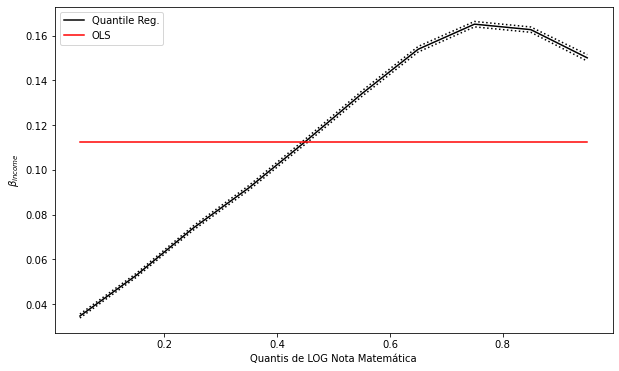

In [125]:
plt.figure(figsize=(10, 6))
n = models.shape[0]
p1 = plt.plot(models.q, models.B, color="black", label="Quantile Reg.")
p2 = plt.plot(models.q, models.upperbound, linestyle="dotted", color="black")
p3 = plt.plot(models.q, models.lowerbound, linestyle="dotted", color="black")
p4 = plt.plot(models.q, [ols["b"]] * n, color="red", label="OLS")
#p5 = plt.plot(models.q, [ols["lb"]] * n, linestyle="dotted", color="red")
#p6 = plt.plot(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
plt.ylabel(r"$\beta_{income}$")
plt.xlabel("Quantis de LOG Nota Matemática")
plt.legend()
plt.show()

Regressão Quantílica Múltipla

In [128]:
enem19.columns

Index(['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA', 'TP_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC',
       'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC',
       'TP_SIT_FUNC_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
       'NU_NOTA_MT', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO',
       'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q012', 'Q019', 'Q022', 'Q024', 'Q025', 'NT_MEDIA',
       'LOG_NT_MEDIA', 'LOG_NT_MT'],
      dtype='object')